# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [1]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import os
import re
import itertools
import pandas as pd
from collections import defaultdict

In [2]:
# default if not using SLURM array
cat_area_per_vol = 3e6 # m2/m3
temperature_c = 400 # ºC
rtol = 1e-9
atol = 1e-22
residual_threshold = 5e-3

# input file containing the reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'
#cti_file = '../RMG-model/cantera/chem0050.cti'

In [33]:
cat_area_per_vol_options = [3e2, 3e3, 3e4, 3e5, 6e5, 9e5, 1.2e6, 3e6, 3e7, 3e8] # m2/m3
temperature_c_options = [200, 300, 400, 500, 600] # ºC

cat_area_per_vol_options = [3e3, 3e4, 3e5, 3e6, 3e7, 3e8] # m2/m3
temperature_c_options = [200, 300, 400, 500] # ºC
rtol_options = [1e-6, 1e-9, 1e-11]
atol_options = [1e-15, 1e-18, 1e-21, 1e-24]

settings  = list(itertools.product(cat_area_per_vol_options,
                                   temperature_c_options,
                                   rtol_options,
                                   atol_options
                                  ))
print(f"Settings aray is from 0 to {len(settings)-1} ")

Settings aray is from 0 to 287 


In [4]:
with open('rocketman_array.sh') as f:
    for l in f:
        m = re.match('#SBATCH --array=(\d+)-(\d+)', l)
        if m:
            print(l)
            start = int(m.group(1))
            end = int(m.group(2))
assert (start, end) == (0, len(settings)-1 ), "SLURM array doesn't match settings array"

#SBATCH --array=0-287%100



In [5]:
task_number = int(os.getenv('SLURM_ARRAY_TASK_ID', default='0'))
task_min = int(os.getenv('SLURM_ARRAY_TASK_MIN', default='0'))
task_max = int(os.getenv('SLURM_ARRAY_TASK_MAX', default='0'))

if task_max > 0:
    print("Using SLURM array job.")
    
    cti_file = 'chem_annotated.cti'
    print(f"Using cantera input file {os.path.abspath(cti_file)}")

    print(f"Task ID {task_number} in array from {task_min} to {task_max}")

    cat_area_per_vol, temperature_c, rtol, atol = settings[task_number]


In [6]:
if task_number == 0:
    import json
    setting_file_directory = '..' if task_max else 'rocketman'
    with open(os.path.join(setting_file_directory,'settings.json'),'w') as fp:
        json.dump(settings, fp)

In [7]:
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
print(f"Initial temperature      {temperature_c :.1f} ºC")
print(f"Solver RTOL              {rtol :.1e}")
print(f"Solvel ATOL              {atol :.1e}")

Catalyst area per volume 3.00e+06 m2/m3
Initial temperature      400.0 ºC
Solver RTOL              1.0e-09
Solvel ATOL              1.0e-22


In [8]:
gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [9]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [ +165 minor]              0                0



In [10]:
print(", ".join(gas.species_names))

Ne, NH3(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), O(36), Ar(37), HO2(39), H2O2(40), HOCO(41), CH2(42), CH2(S)(43), CH(44), CH2OH(45), CH3O(46), HCOH(47), CH3OO(48), CH2CO(49), C2H3(50), C(51), C2H2(52), C2H(53), CH3OOH(54), CH2OOH(55), HOCH2O(56), HOCHO(57), C2H5O(58), C2H5O2(59), C2H5O2(60), cC2H4O(61), CH2CHO(62), H2CC(63), CH3CO(64), C2H4O(65), C2H5O(66), C2H3O2(67), CHCHO(68), OCHCHO(69), HCCO(70), HCCOH(71), CHCHOH(72), C2(73), C2O(74), C2H6O(75), C2H5O(76), C2H5O3(77), cC2H3O(78), C2H3O3(79), OCHCO(80), C2H6O2(81), C2H5O2(82), C2H4O2(83), OCHO(84), NH2(85), NH(86), HNO(87), H2NO(88), HON(89), N(90), NNH(91), HONO(92), HNOH(93), HNO2(94), NO3(95), N2H2(96), H2N2(97), N2H3(98), N2H4(99), HCN(100), CN(101), HNC(102), NCO(103), HOCN(104), HNCO(105), NCCN(106), HNCN(107), NCN(108), HNCNH(109), HCNO(110), CH3CN(111), CH2C

In [11]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), H2NX(201), H3NX(202), H2NOX(203), H2NOX(204), H3NOX(205), HNO3X(208), CH3OX(210), CH4OX(211), NO2X(214), NOX(215), NOJX(216), H2X(218), CH2OX(224), HNX(519), HNOX(520), CH2OX(522), H2NOX(533), CHOX(588), SX(589), SX(590), HNO2X(594), NX(617), SX(618), CH4NX(666), CH3NX(667), CH2NX(668), H2N2X(671), HONOX(672), HNOX(744), SX(935), CNOX(943), N2OX(946), SX(955), SX(1252), SX(1484)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [12]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [13]:
#######################################################################
# Input Parameters for combustor
#######################################################################
mass_flow_rate =  0.5e-3 # kg/s
#temperature_c = 550.0  # Initial Temperature in Celsius
print(f"Initial temperature {temperature_c :.1f} ºC")
pressure = ct.one_atm # constant

length = 1.1 * cm  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter
cat_specific_area = 140 # m2/g
print(f"Catalyst specific area {cat_specific_area :.2e} m2/g")
cat_density = 2 / cm**3 # 2 g/m3
print(f"Catalyst density {cat_density :.2e} g/m3")
cat_area_per_reactor_vol = cat_specific_area * cat_density # m2/m3
print(f"Catalyst area per total reactor volume {cat_area_per_reactor_vol :.2e} m/m3")
cat_area_per_gas_vol = cat_area_per_reactor_vol / porosity # porosity is gas vol per reactor vol
print(f"Catalyst area per gas volume {cat_area_per_gas_vol :.2e} m/m3")

#cat_area_per_vol =  cat_area_per_gas_vol * 1e-3 # REDUCE BY A LOT
print(f"\nCatalyst area per volume in use for this simulation: {cat_area_per_vol :.2e} m2/m3")



Initial temperature 400.0 ºC
Catalyst specific area 1.40e+02 m2/g
Catalyst density 2.00e+06 g/m3
Catalyst area per total reactor volume 2.80e+08 m/m3
Catalyst area per gas volume 7.37e+08 m/m3

Catalyst area per volume in use for this simulation: 3.00e+06 m2/m3


In [14]:
output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2201

#####################################################################

temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# From HAN-molefractions.ipynb
feed_mole_fractions = {
    'NH3(2)': 0.031,
    'NH2OH(3)': 0.32,
    'HNO3(4)': 0.35,
    'CH3OH(5)': 0.21,
    'H2O(6)': 0.09,
}
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions


# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = temperature_kelvin, pressure
surf.coverages = 'X(1):1.0'

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)

In [15]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of gas")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)               -0.003
315 : NH2OH(3) (+M) <=> NH2(85) + OH(24) (+M)              8e-09
 88 : H2NO(88) + H2NO3(239) <=> HNO3(4) + NH2OH(3)        -8e-11
 70 : H(20) + H2NO(88) <=> NH2OH(3)                       -4e-12
 87 : H2NO3(239) + HNOH(93) <=> HNO3(4) + NH2OH(3)        -2e-14
 61 : H(20) + HNOH(93) <=> NH2OH(3)                       -2e-15
 42 : CH3(18) + OH(24) <=> CH3OH(5)                       -5e-17

Highest net rates of progress, surface
  0 : H2O(6) + X(1) <=> H2OX(30)                           8e+05
  1 : NH2OH(3) + X(1) <=> H3NOX(205)                       3e+05
  2 : HNO3(4) + X(1) <=> HNO3X(208)                        2e+05
  3 : CH3OH(5) + X(1) <=> CH4OX(211)                       2e+05
  4 : NH3(2) + X(1) <=> H3NX(202)                          4e+04
 13 : NH2OH(3) + 2 X(1) <=> H2NOX(204) + HX(26)            3e+01
 15 : CH3OH(5) + 2 X(1) <=> CH3OX(210) + HX(26)            3e+01

Highest forwa

In [16]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
364 : HCO(22) + NO(10) <=> CHNO2(393)                    2.5e+17
370 : HCO(22) + NO2(9) <=> CHNO3(368)                    2.5e+17
338 : CH2OH(45) + NO(10) <=> OCNDO(940)                  2.5e+17
239 : CH2OH(45) + NO2(9) <=> S(1095)                     2.5e+17
238 : CH2OH(45) + H2NO(88) <=> S(736)                    2.5e+17
372 : CH2OH(45) + HNOH(93) <=> ONCO(525)                 2.5e+17
366 : H2NO(88) + HCO(22) <=> S(574)                      1.6e+15

Highest forward rate constants, surface
151 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 17 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 19 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
133 : CH4NX(666) + X(1) <=> CH3NX(667) + HX(26)          7.4e+20
 99 : CH2OX(522) + X(1) <=> CHOX(588) + HX(26)           3.7e+20
115 : CH3NX(667) + X(1) <=> CH2NX(668) + HX(26)          3.7e+20
 73 : CH3NX(667) + X(1) <=> CHX(35) + H2NX(201)          2.9e+19

Highest rev

In [17]:
def fix_rates(phase, limit):
    """
    Fix reverse reaction rates that are too fast.
    """
    for i in np.argsort(abs(phase.reverse_rate_constants))[-1:0:-1]:
        if phase.reverse_rate_constants[i] < limit:
            break
        print(f"Before: {i:3d} : {phase.reaction_equation(i):48s}  {phase.reverse_rate_constants[i]:8.1e}")
        multiplier = limit / phase.reverse_rate_constants[i]
        phase.set_multiplier(multiplier, i)
        print(f"After:  {i:3d} : {phase.reaction_equation(i):48s}  {phase.reverse_rate_constants[i]:8.1e}")
        
#fix_rates(gas, 1e18)
#fix_rates(surf, 1e21)

In [18]:
def save_flux_diagrams(*phases, suffix=''):
    """
    Saves the flux diagrams. The filenames have a suffix if provided,
    so you can keep them separate and not over-write.
    """
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name

            diagram = ct.ReactionPathDiagram(phase_object, element)
            diagram.title = f'Reaction path diagram following {element} in {phase}'
            diagram.label_threshold = 0.01

            dot_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.dot"
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            img_path = os.path.join(os.getcwd(), img_file)
            diagram.write_dot(dot_file)
            #print(diagram.get_data())

            print(f"Wrote graphviz input file to '{os.path.join(os.getcwd(), dot_file)}'.")
            os.system(f'dot {dot_file} -Tpng -o{img_file} -Gdpi=200')
            print(f"Wrote graphviz output file to '{img_path}'.")

def show_flux_diagrams(*phases, suffix='', embed=False):
    """
    Shows the flux diagrams in the notebook.
    Loads them from disk.
    Does not embed them, to keep the .ipynb file small,
    unless embed=True. Use embed=True if you might over-write the files,
    eg. you want to show flux at different points.
    """
    import IPython
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            display(IPython.display.HTML(f'<hr><h2>{element} {phase}</h2>'))
            if embed:
                display(IPython.display.Image(filename=img_file,width=400,embed=True))
            else:
                display(IPython.display.Image(url=img_file,width=400,embed=False))


def integrated_flux_diagrams():
    """This is a code fragment. Not working. Do not use it."""
    for element in 'CHON':
        diagrams = [ct.ReactionPathDiagram(surf, element), ct.ReactionPathDiagram(gas, element)]
        for diagram in diagrams:
            data = diagram.get_data()
            split_data = data.split("\n")
            for line in split_data[2:]:
                if len(line.split()) == 0: # skip empty line
                    continue
                s1, s2, fwd, rev = line.split()
                net = float(fwd) - float(rev)
                if net == 0.0:
                    continue
                flux_pair = (s1, s2)
                integration_flux_data[flux_pair] += net
    

In [19]:
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions
surf.coverages = 'X(1):1.0'
#surf.coverages = starting_coverages

In [ ]:
fix_rates(gas, 1e18)

    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha
      0.000000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.050000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.100000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.150000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.200000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.250000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.300000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.350000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.400000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.450000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.500000    400.0    0.030969    0.319680    0.349650   0.209790  0.0e+00
      0.550000    400.0    0.030969    0.

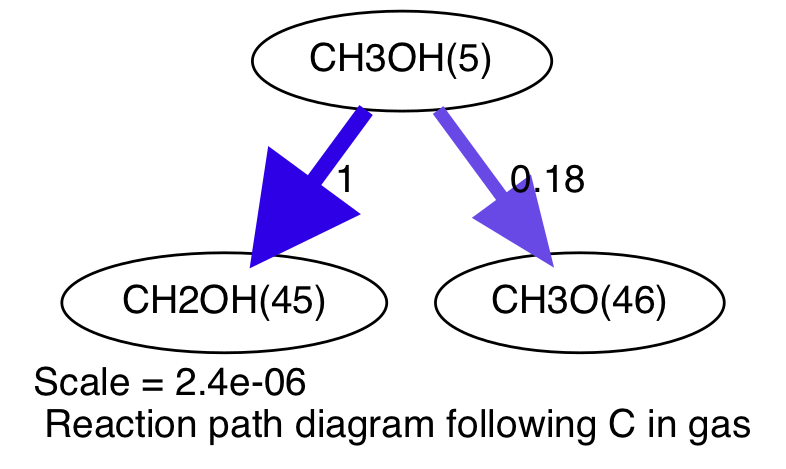

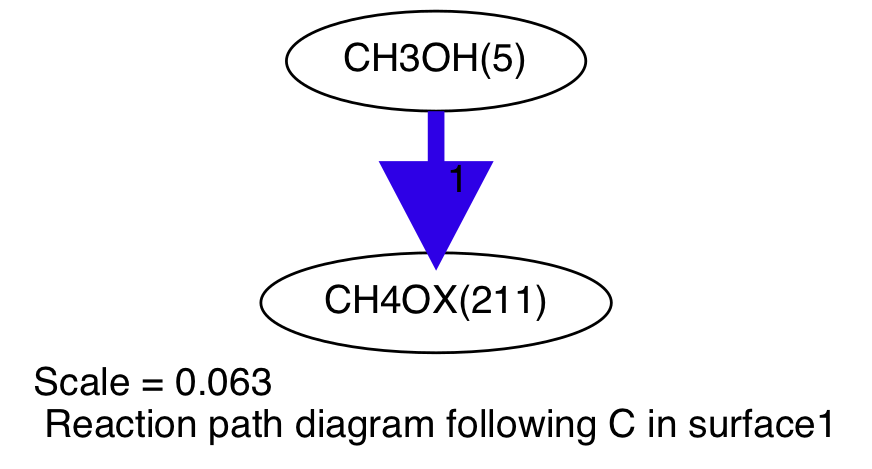

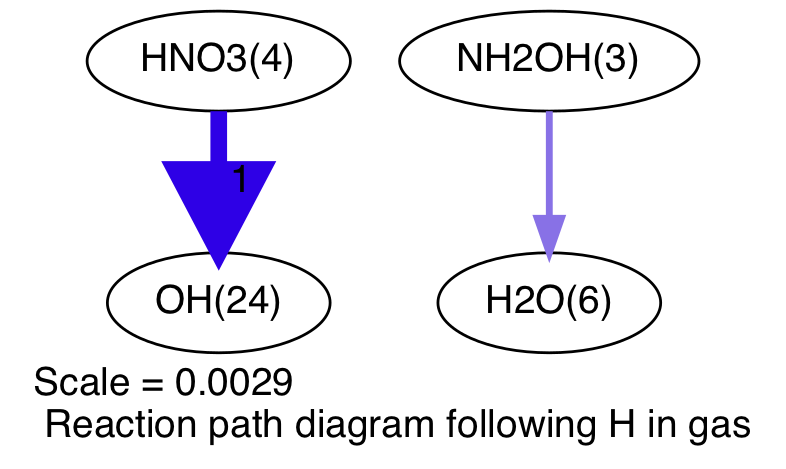

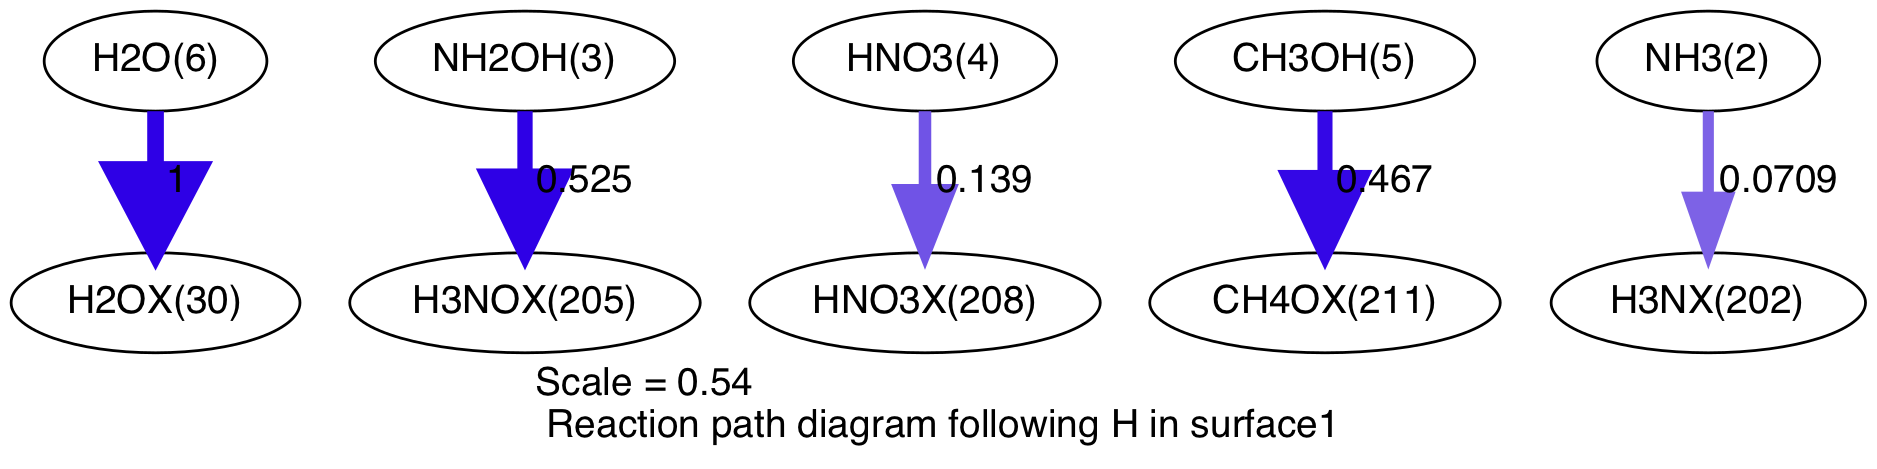

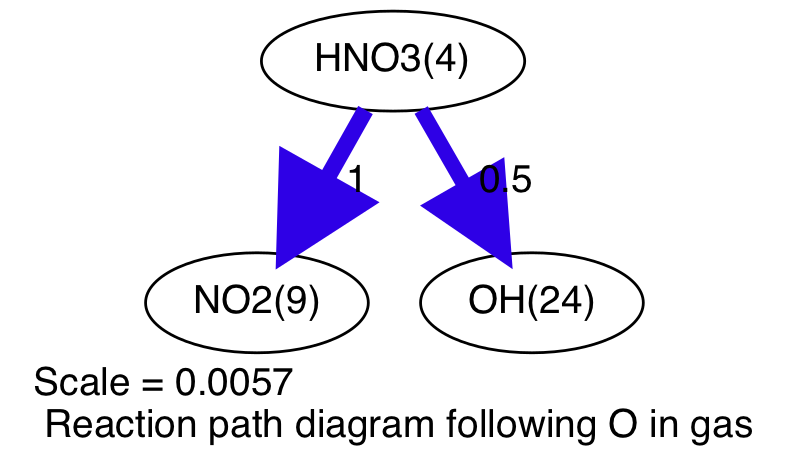

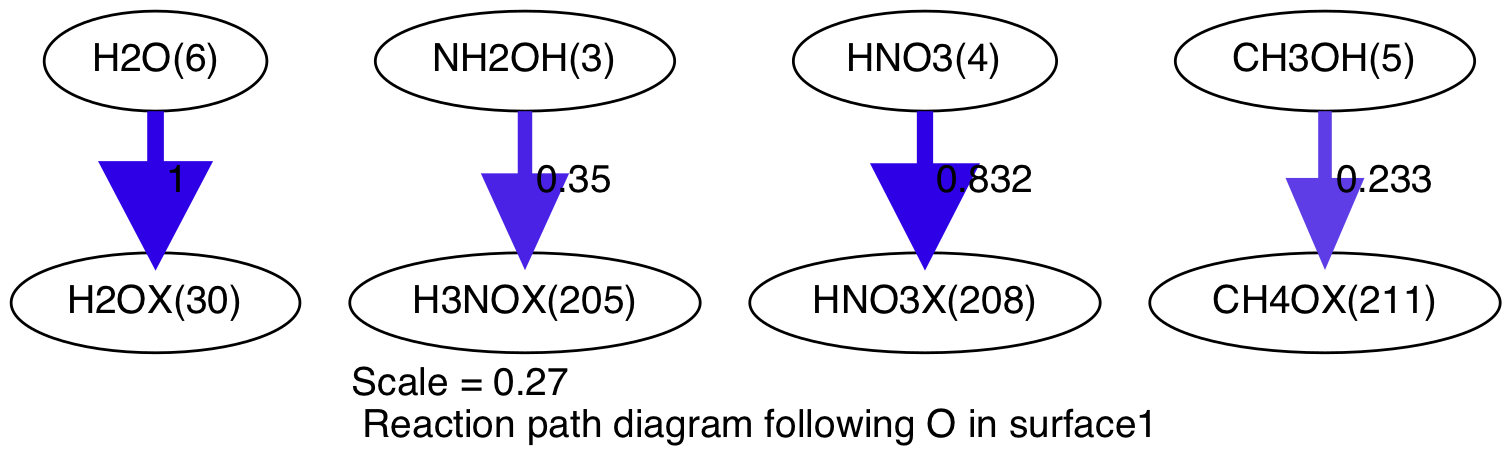

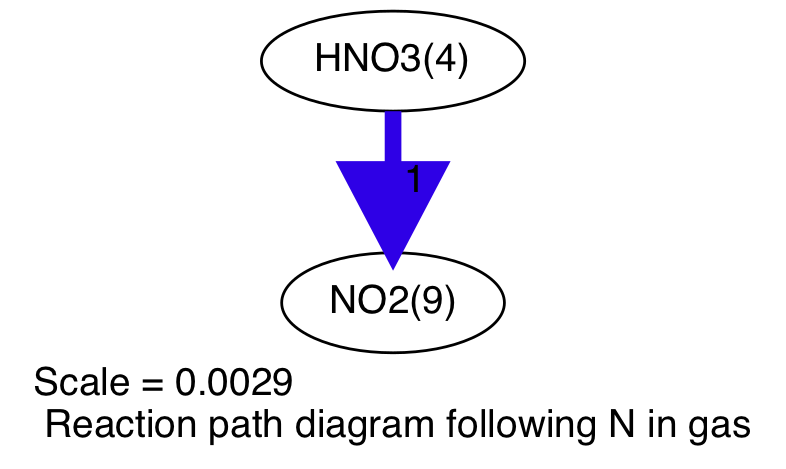

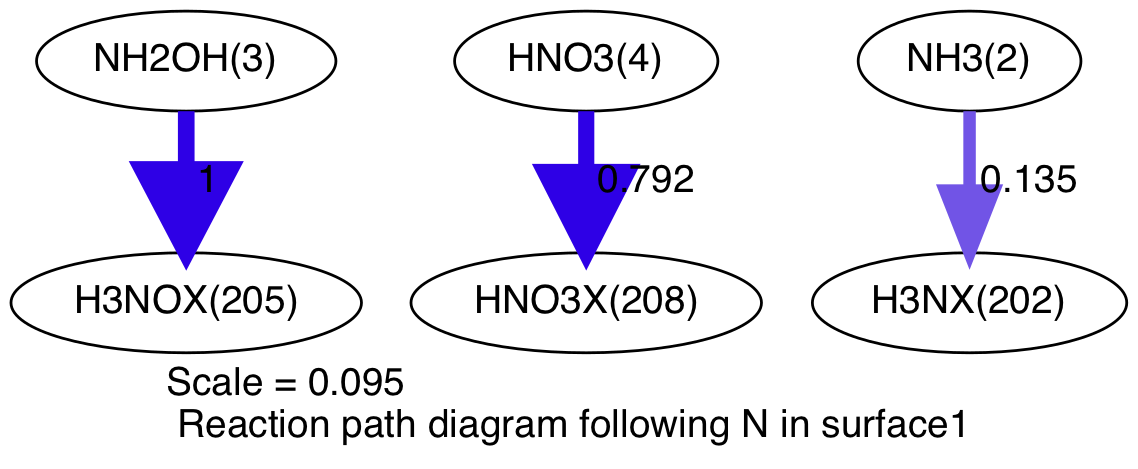

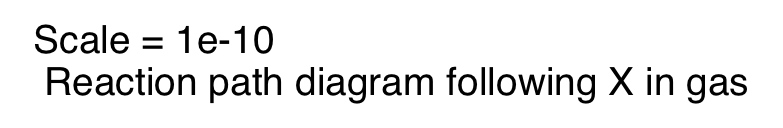

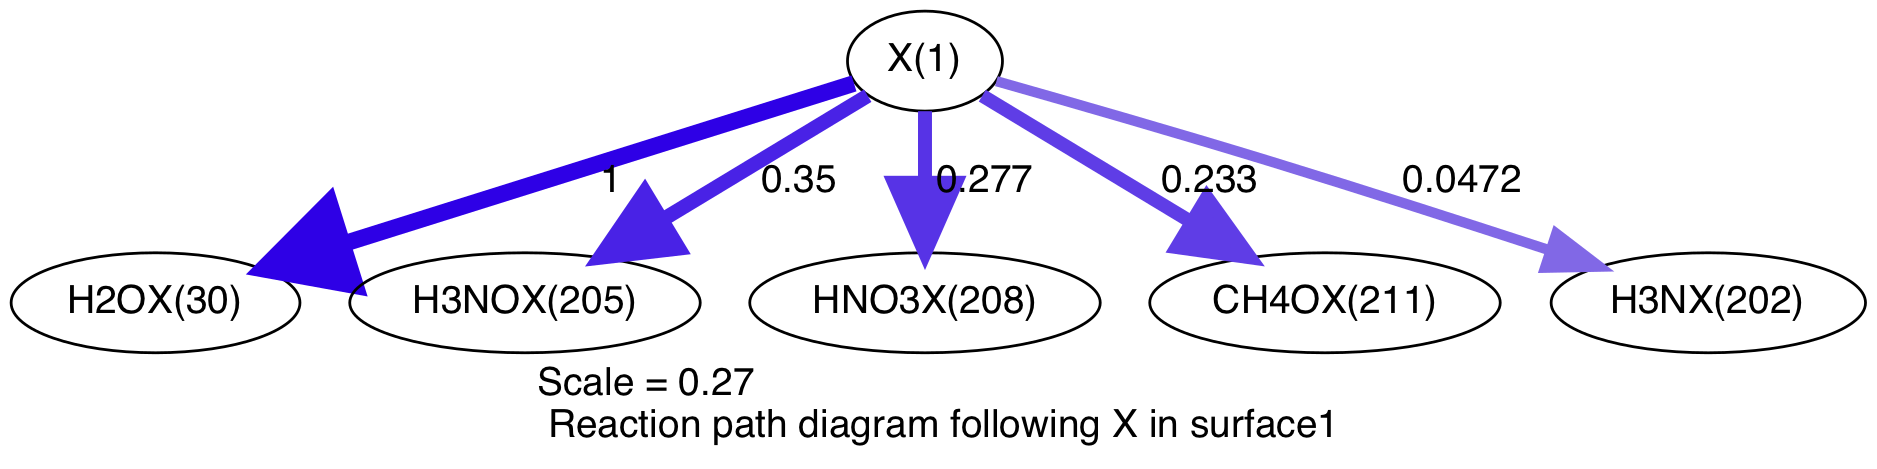

      1.000000    399.6    0.030970    0.319700    0.349681   0.209803  1.0e+00
      1.050000    399.6    0.030970    0.319700    0.349682   0.209803  1.0e+00
      1.100000    399.6    0.030970    0.319700    0.349682   0.209803  1.0e+00
      1.150000    399.6    0.030970    0.319700    0.349682   0.209803  1.0e+00
      1.200000    399.6    0.030970    0.319700    0.349682   0.209803  1.0e+00
      1.250000    399.6    0.030970    0.319700    0.349683   0.209803  1.0e+00
      1.300000    399.6    0.030970    0.319700    0.349683   0.209803  1.0e+00
      1.350000    399.6    0.030970    0.319701    0.349683   0.209803  1.0e+00
      1.400000    399.6    0.030970    0.319701    0.349683   0.209803  1.0e+00
      1.450000    399.5    0.030970    0.319701    0.349684   0.209804  1.0e+00
      1.500000    399.5    0.030970    0.319701    0.349684   0.209804  1.0e+00
      1.550000    399.5    0.030970    0.319701    0.349684   0.209804  1.0e+00
      1.600000    399.5    0.030970    0

      6.150000    399.1    0.030969    0.319714    0.349711   0.209812  1.0e+00
      6.200000    399.1    0.030969    0.319714    0.349711   0.209813  1.0e+00
      6.250000    399.1    0.030969    0.319714    0.349711   0.209813  1.0e+00
      6.300000    399.1    0.030969    0.319714    0.349712   0.209813  1.0e+00
      6.350000    399.1    0.030969    0.319715    0.349712   0.209813  1.0e+00
      6.400000    399.1    0.030969    0.319715    0.349712   0.209813  1.0e+00
      6.450000    399.1    0.030969    0.319715    0.349713   0.209813  1.0e+00
      6.500000    399.1    0.030969    0.319715    0.349713   0.209813  1.0e+00
      6.550000    399.1    0.030969    0.319715    0.349714   0.209813  1.0e+00
      6.600000    399.1    0.030969    0.319715    0.349714   0.209813  1.0e+00
      6.650000    399.1    0.030969    0.319715    0.349714   0.209813  1.0e+00
      6.700000    399.1    0.030969    0.319715    0.349714   0.209813  1.0e+00
      6.750000    399.1    0.030969    0

In [20]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='on')
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24

# set relative and absolute tolerances on the simulation
sim.rtol = rtol
sim.atol = atol

sim.verbose = False

# surf.set_multiplier(0.)  # turn off surface reactions
# surf.set_multiplier(1e6)  # make surface reactions a million times faster

r.volume = r_vol
rsurf.area = cat_area

integration_flux_data = defaultdict(float)

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['gas_heat','surface_heat','alpha'])

print('    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha')
for n in range(NReactors):
    """
    if n == 0: # first coulpe of reactors are tiny
        surf.set_multiplier(0.)
        r.volume = r_vol * 1e-2
        rsurf.area = cat_area * 1e-2
    if n == 3:
        r.volume = r_vol
        rsurf.area = cat_area"""
        
    if n == 0: # start off with inert packing, no surface reactions
        surf.set_multiplier(0.)
    if n == int(0.001 * NReactors / length): # after 1 mm, catalyst
        surf.set_multiplier(1)
        
        fix_rates(surf, 1e22)
        save_flux_diagrams(gas, surf, suffix='1mm')
        show_flux_diagrams(gas, surf, suffix='1mm', embed=True)
    
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY
    cov = surf.coverages
    upstream.syncState()
    sim.reinitialize()
    try:
#       the default is residual_threshold = sim.rtol*10
        sim.advance_to_steady_state(residual_threshold = residual_threshold)

    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        surf.coverages = cov
        r.syncState()
        sim.reinitialize()
        new_target_time = 0.01 * t
        print(f"Couldn't reach {t:.1g} s so going to try {new_target_time:.1g} s")
        #save_flux_diagrams(gas, surf)
        #show_flux_diagrams(gas, surf, embed=True)
        report_rates()
        report_rate_constants()
        try:
            sim.advance(new_target_time)
        except ct.CanteraError:
            outfile.close()
            raise()
            #report_rate_constants()
 
    dist = n * r_len * 1.0e3   # distance in mm
        
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surface_heat = cat_area_per_vol * np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = surface_heat / (surface_heat + gas_heat) # fraction of heat release that is on surface.

    if not n % 10:
        print('    {:10f}  {:7.1f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, r.T-273.15, *gas['NH3(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [gas_heat, surface_heat, alpha])
    

outfile.close()
print("Results saved to '{0}'".format(output_filename))

with open("integration_flux_data.txt",'w') as f:
    for (sp1,sp2),flux in integration_flux_data.items():
        f.write("{} {} {}\n".format(sp1,sp2,flux))
            

In [21]:
surf()


  surface1:

       temperature         671.894  K
          pressure          101325  Pa
           density     4.84402e-06  kg/m^3
  mean mol. weight         195.087  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy         -125.18       -2.442e+04     J
   internal energy         -125.18       -2.442e+04     J
           entropy         0.16897            32.96     J/K
    Gibbs function         -238.71       -4.657e+04     J
 heat capacity c_p        0.050404            9.833     J/K
 heat capacity c_v        0.050404            9.833     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              X(1)       0.999869         0.999847      -0.00017012
            HX(26)    1.26174e-08      1.26823e-08         -23.9699
            OX(27)    2.10837e-09      2.28123e-09         -47.4656
          CH3X(28)    9

In [22]:
sim.time

1.396292552422441e-10

In [23]:
gas.TDY = TDY
r.syncState()
r.thermo.T

671.8947976361959

In [24]:
r.thermo.X - gas.X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
report_rate_constants()


Highest forward rate constants, gas
364 : HCO(22) + NO(10) <=> CHNO2(393)                    2.6e+17
370 : HCO(22) + NO2(9) <=> CHNO3(368)                    2.6e+17
338 : CH2OH(45) + NO(10) <=> OCNDO(940)                  2.6e+17
239 : CH2OH(45) + NO2(9) <=> S(1095)                     2.6e+17
238 : CH2OH(45) + H2NO(88) <=> S(736)                    2.6e+17
372 : CH2OH(45) + HNOH(93) <=> ONCO(525)                 2.6e+17
366 : H2NO(88) + HCO(22) <=> S(574)                      1.6e+15

Highest forward rate constants, surface
151 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 17 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 19 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
133 : CH4NX(666) + X(1) <=> CH3NX(667) + HX(26)          7.4e+20
 99 : CH2OX(522) + X(1) <=> CHOX(588) + HX(26)           3.7e+20
115 : CH3NX(667) + X(1) <=> CH2NX(668) + HX(26)          3.7e+20
 73 : CH3NX(667) + X(1) <=> CHX(35) + H2NX(201)          2.9e+19

Highest rev

In [26]:
sim.verbose

False

<BarContainer object of 1582 artists>

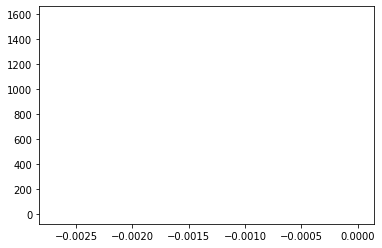

In [27]:
plt.barh(np.arange(len(gas.net_rates_of_progress)),gas.net_rates_of_progress)

In [28]:
gas.T

671.8947976361959

In [29]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ne,NH3(2),NH2OH(3),HNO3(4),CH3OH(5),H2O(6),N2(7),...,HNOX(744),SX(935),CNOX(943),N2OX(946),SX(955),SX(1252),SX(1484),gas_heat,surface_heat,alpha
0,0.000,400.000000,1.000000,-6.575562e-40,0.030969,0.31968,0.349650,0.209790,0.089910,-3.816232e-40,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.889638e+05,0.000000e+00,0.0
1,0.005,400.000000,1.000000,-6.575553e-40,0.030969,0.31968,0.349650,0.209790,0.089910,-3.816226e-40,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.889458e+05,0.000000e+00,0.0
2,0.010,400.000000,1.000000,-6.575543e-40,0.030969,0.31968,0.349650,0.209790,0.089910,-3.816221e-40,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.889274e+05,0.000000e+00,0.0
3,0.015,400.000000,1.000000,-6.575533e-40,0.030969,0.31968,0.349650,0.209790,0.089910,-3.816215e-40,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.889089e+05,0.000000e+00,0.0
4,0.020,400.000000,1.000000,-6.575523e-40,0.030969,0.31968,0.349650,0.209790,0.089910,-3.816209e-40,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.888903e+05,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,10.980,398.746962,0.997613,-5.591502e-29,0.030968,0.31972,0.349733,0.209817,0.089762,-3.817168e-40,...,1.344542e-29,2.596845e-29,3.227302e-28,2.586123e-37,3.098406e-26,4.386458e-29,2.774884e-18,5.505431e+05,-5.242229e+13,1.0
2197,10.985,398.745986,0.997611,-5.591504e-29,0.030968,0.31972,0.349733,0.209817,0.089762,-3.817170e-40,...,1.350360e-29,2.597257e-29,3.240457e-28,2.601462e-37,3.112782e-26,4.387996e-29,2.785638e-18,1.053846e+07,-5.241542e+13,1.0
2198,10.990,398.745961,0.997611,-5.591505e-29,0.030968,0.31972,0.349733,0.209817,0.089762,-3.817170e-40,...,1.350510e-29,2.597267e-29,3.240795e-28,2.601856e-37,3.113151e-26,4.388035e-29,2.785914e-18,5.507565e+05,-5.241524e+13,1.0
2199,10.995,398.744798,0.997608,-5.591508e-29,0.030968,0.31972,0.349734,0.209817,0.089762,-3.817172e-40,...,1.357472e-29,2.597758e-29,3.256521e-28,2.620237e-37,3.130352e-26,4.389869e-29,2.798765e-18,5.507239e+05,-5.240706e+13,1.0


In [30]:
def xlabels():
    ticks = []
    labels = []
    mm = 0
    while mm < length*1000:
        ticks.append( int(NReactors * mm * 0.001 / length ) )
        labels.append( str(mm) )
        mm += 1
    labels[-1] = labels[-1] + ' mm'
    plt.xticks(ticks, labels)
    plt.xlabel("Distance down reactor")

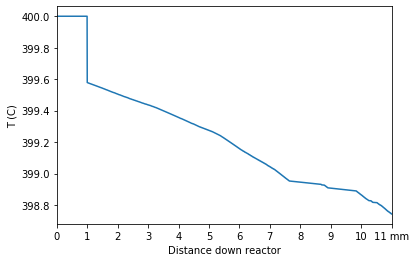

In [31]:
data['T (C)'].plot()
plt.ylabel('T (C)')
xlabels()

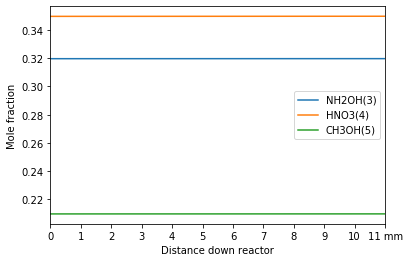

In [34]:
data[['NH2OH(3)', 'HNO3(4)', 'CH3OH(5)']].plot()
plt.ylabel('Mole fraction')
xlabels()

In [35]:
list(data.columns)[:4]

['Distance (mm)', 'T (C)', 'P (atm)', 'Ne']

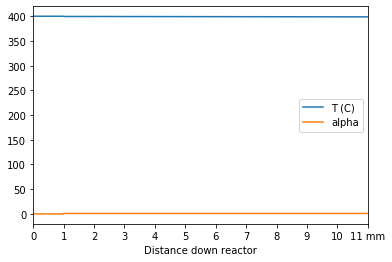

In [36]:
data[['T (C)', 'alpha']].plot()
xlabels()

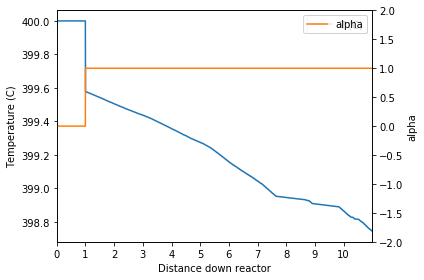

In [37]:
ax1 = data['T (C)'].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.legend()
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, color='tab:orange')
ax2.set_ylim(-2, 2)
plt.legend()
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('temperature-and-alpha.pdf')
plt.show()

In [38]:
data.columns

Index(['Distance (mm)', 'T (C)', 'P (atm)', 'Ne', 'NH3(2)', 'NH2OH(3)',
       'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)',
       ...
       'HNOX(744)', 'SX(935)', 'CNOX(943)', 'N2OX(946)', 'SX(955)', 'SX(1252)',
       'SX(1484)', 'gas_heat', 'surface_heat', 'alpha'],
      dtype='object', length=218)

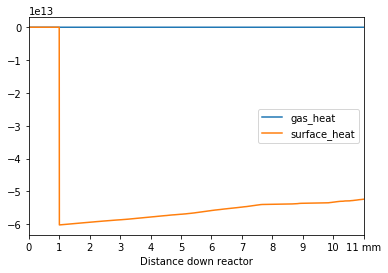

In [39]:
data[['gas_heat','surface_heat']].plot()
#plt.ylim(-1e7, 1e7)
xlabels()
plt.savefig('gas_and_surface_heat.pdf')
plt.show()


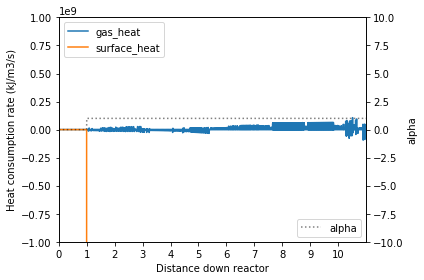

In [40]:
ax1 = data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
xlabels()
plt.ylabel('Heat consumption rate (kJ/m3/s)')
plt.legend(loc='upper left')
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, style='k:', alpha=0.5)
ax2.set_ylim(-10, 10)
plt.legend(loc='lower right')
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('heats-and-alpha.pdf')
plt.show()

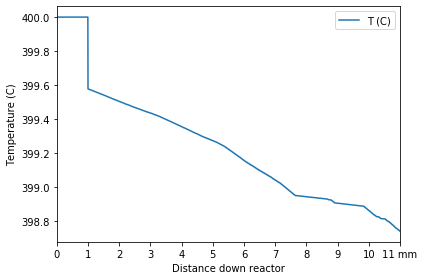

In [41]:
data[['T (C)']].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.tight_layout()
plt.savefig('temperature.pdf')
plt.show()

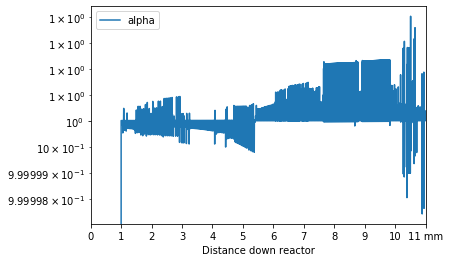

In [42]:
data[['alpha']].plot(logy=True)
xlabels()

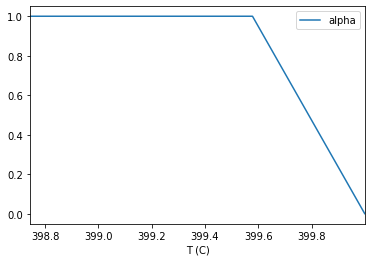

In [43]:
data.plot(x='T (C)',y='alpha')


In [44]:
specs = list(data.columns)
specs = specs[4:-3]
excluded = [s for s in data.columns if s not in specs]
gas_species = [s for s in specs if 'X' not in s ]
adsorbates = [s for s in specs if 'X' in s]

excluded, gas_species, adsorbates

(['Distance (mm)',
  'T (C)',
  'P (atm)',
  'Ne',
  'gas_heat',
  'surface_heat',
  'alpha'],
 ['NH3(2)',
  'NH2OH(3)',
  'HNO3(4)',
  'CH3OH(5)',
  'H2O(6)',
  'N2(7)',
  'O2(8)',
  'NO2(9)',
  'NO(10)',
  'N2O(11)',
  'CO2(12)',
  'H2(13)',
  'CO(14)',
  'CH4(15)',
  'C2H6(16)',
  'CH2O(17)',
  'CH3(18)',
  'C3H8(19)',
  'H(20)',
  'C2H5(21)',
  'HCO(22)',
  'CH3CHO(23)',
  'OH(24)',
  'C2H4(25)',
  'O(36)',
  'Ar(37)',
  'HO2(39)',
  'H2O2(40)',
  'HOCO(41)',
  'CH2(42)',
  'CH2(S)(43)',
  'CH(44)',
  'CH2OH(45)',
  'CH3O(46)',
  'HCOH(47)',
  'CH3OO(48)',
  'CH2CO(49)',
  'C2H3(50)',
  'C(51)',
  'C2H2(52)',
  'C2H(53)',
  'CH3OOH(54)',
  'CH2OOH(55)',
  'HOCH2O(56)',
  'HOCHO(57)',
  'C2H5O(58)',
  'C2H5O2(59)',
  'C2H5O2(60)',
  'cC2H4O(61)',
  'CH2CHO(62)',
  'H2CC(63)',
  'CH3CO(64)',
  'C2H4O(65)',
  'C2H5O(66)',
  'C2H3O2(67)',
  'CHCHO(68)',
  'OCHCHO(69)',
  'HCCO(70)',
  'HCCOH(71)',
  'CHCHOH(72)',
  'C2(73)',
  'C2O(74)',
  'C2H6O(75)',
  'C2H5O(76)',
  'C2H5O3(77)',
  

/Users/rwest/anaconda/envs/rmg3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


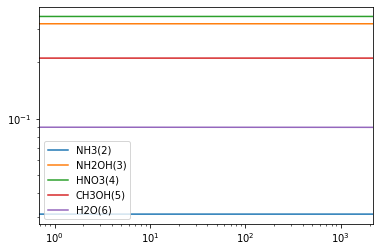

In [45]:
data[gas_species[0:5]].plot(logy=True, logx=True)

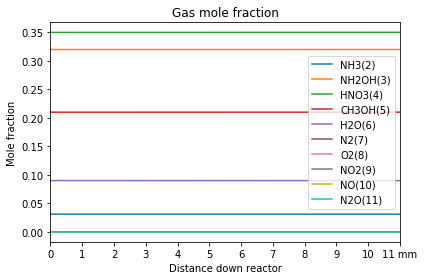

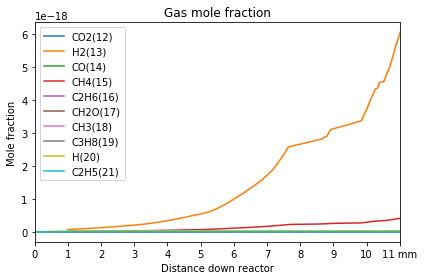

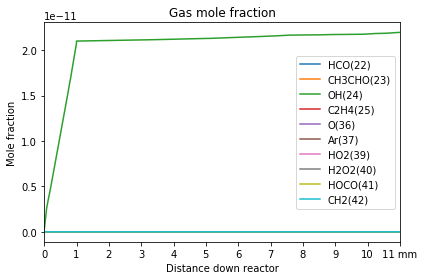

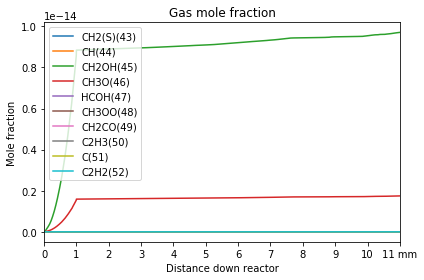

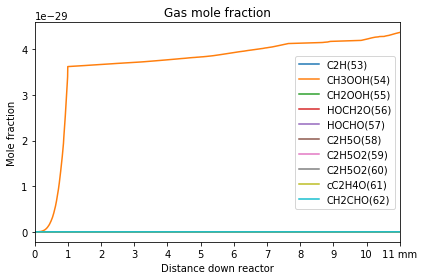

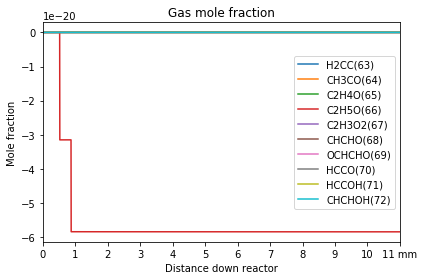

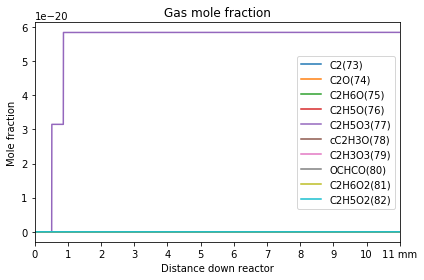

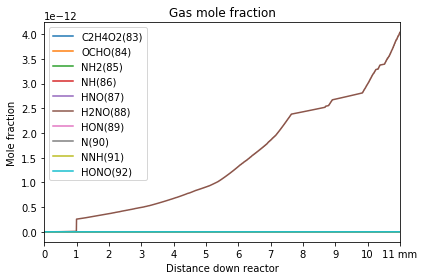

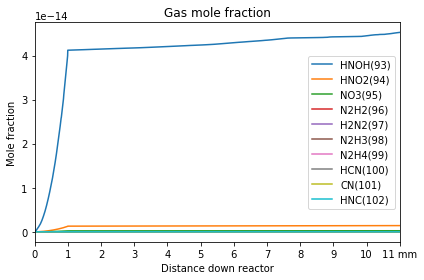

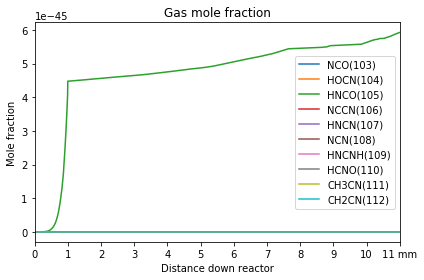

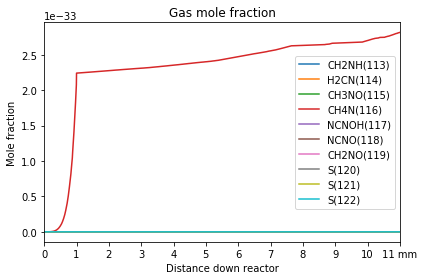

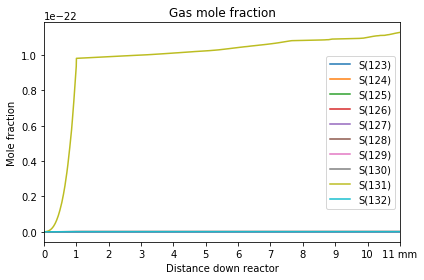

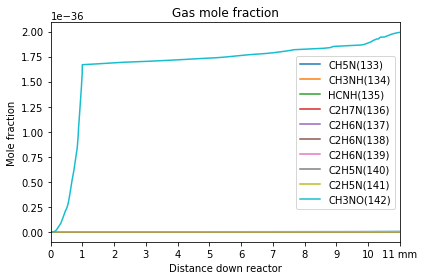

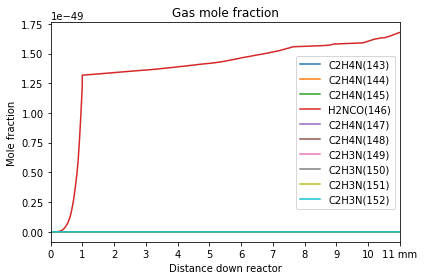

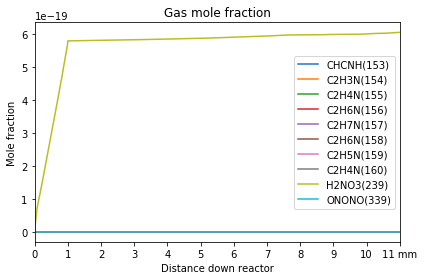

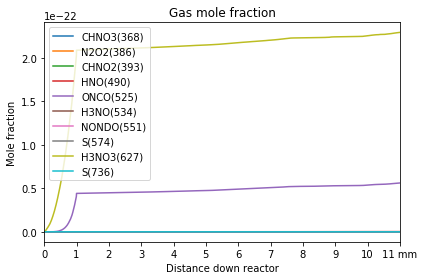

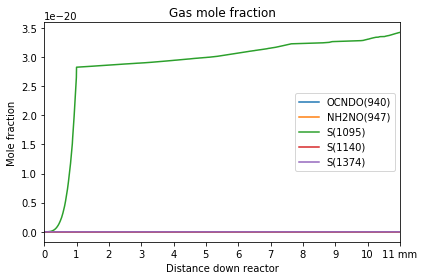

In [46]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='Gas mole fraction', logy=False)
    xlabels()
    plt.ylabel('Mole fraction')
    plt.tight_layout()
    plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    


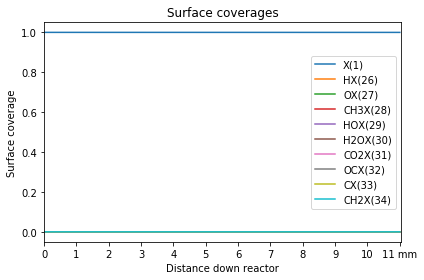

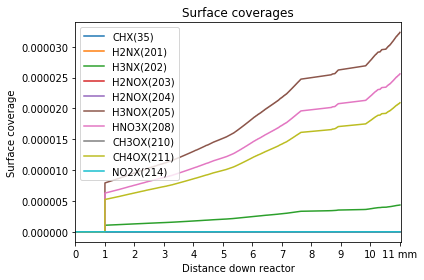

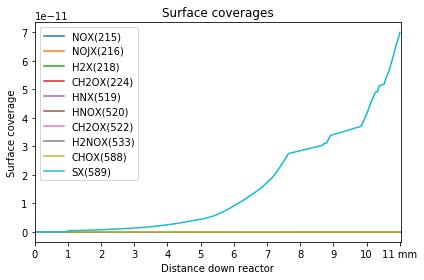

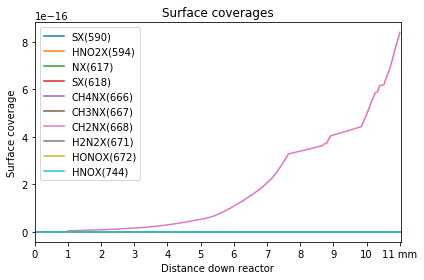

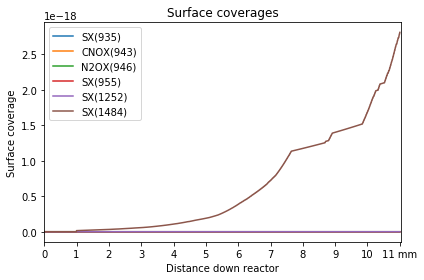

In [47]:
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='Surface coverages', logy=False)
    xlabels()
    plt.xlim(0,len(data)+5)
    plt.ylabel('Surface coverage')
    plt.tight_layout()
    plt.savefig(f'surface_coverages_{i}.pdf')
    plt.show()

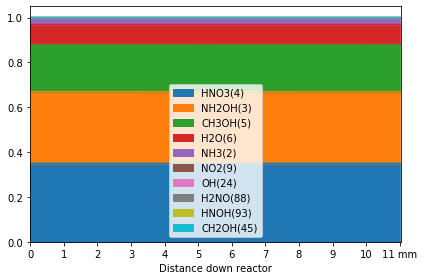

In [48]:
main_gas_species = data[gas_species].max().sort_values(ascending=False)[:10].keys()
data[main_gas_species].plot.area()

xlabels()
plt.xlim(0,len(data)+5)
plt.tight_layout()
plt.savefig(f'gas_mole_fractions_top10.pdf')
plt.show()

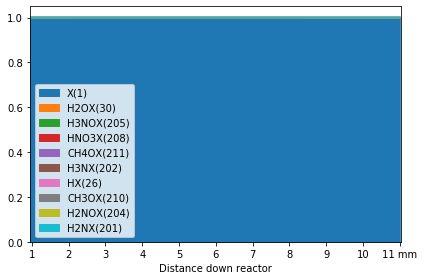

In [49]:
main_adsorbates = data[adsorbates].max().sort_values(ascending=False)[:10].keys()
data[main_adsorbates].plot.area()

xlabels()
plt.xlim(190,len(data)+5)
plt.tight_layout()
plt.savefig(f'surface_coverages_top10.pdf')
plt.show()
    

In [50]:
for a in main_adsorbates:
    s = surf.species(a)
    print(s, s.composition)

<Species X(1)> {'X': 1.0}
<Species H2OX(30)> {'H': 2.0, 'O': 1.0, 'X': 1.0}
<Species H3NOX(205)> {'H': 3.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}
<Species HNO3X(208)> {'H': 1.0, 'N': 1.0, 'O': 3.0, 'X': 1.0}
<Species CH4OX(211)> {'C': 1.0, 'H': 4.0, 'O': 1.0, 'X': 1.0}
<Species H3NX(202)> {'H': 3.0, 'N': 1.0, 'X': 1.0}
<Species HX(26)> {'H': 1.0, 'X': 1.0}
<Species CH3OX(210)> {'C': 1.0, 'H': 3.0, 'O': 1.0, 'X': 1.0}
<Species H2NOX(204)> {'H': 2.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}
<Species H2NX(201)> {'H': 2.0, 'N': 1.0, 'X': 1.0}


In [51]:
surf.coverages

array([9.99868928e-01, 1.26174204e-08, 2.10836928e-09, 9.94995100e-10,
       9.56389500e-10, 4.78429980e-05, 5.10670913e-33, 6.20797118e-20,
       1.45820452e-10, 7.76115459e-17, 6.37269209e-13, 2.55411244e-09,
       4.34943706e-06, 1.81729561e-09, 3.56647157e-09, 3.23326474e-05,
       2.56021639e-05, 3.63448866e-09, 2.09158617e-05, 3.66818411e-15,
       1.06779508e-25, 1.63743523e-33, 5.92066282e-22, 1.17388344e-25,
       3.97248696e-14, 1.64379089e-14, 2.31148169e-21, 1.39846630e-16,
       2.81862940e-16, 7.00436145e-11, 2.62867159e-19, 1.12677597e-19,
       1.71166840e-19, 1.50688499e-30, 9.88796593e-23, 2.07171625e-21,
       8.39604265e-16, 1.31540693e-31, 1.45476149e-21, 1.36447406e-29,
       2.59824873e-29, 3.27232123e-28, 2.63875246e-37, 3.14765319e-26,
       4.39170583e-29, 2.81167337e-18])

In [ ]:
surf.set_multiplier(1)
diagram = ct.ReactionPathDiagram(surf, 'X')
diagram.get_data()